# **combatlearn**: Quick‑Start Demo
This notebook walks through the main **combatlearn** features:
ComBat (Johnson _et al._ 2007), neuroComBat (Fortin _et al._ 2018), and CovBat (Chen _et al._ 2022).

```bash
# If you haven't installed the package yet, run this:
pip install combatlearn
```

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from combatlearn import ComBat

plt.rcParams["figure.dpi"] = 120

In [ ]:
def plot_pca(X, labels, title):
    pca = PCA(n_components=2)
    pts = pca.fit_transform(X)
    _ = plt.figure(dpi=150)
    for b in np.unique(labels):
        idx = labels == b
        plt.scatter(pts[idx, 0], pts[idx, 1], label=f"batch {b}")
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.show()

## Original data

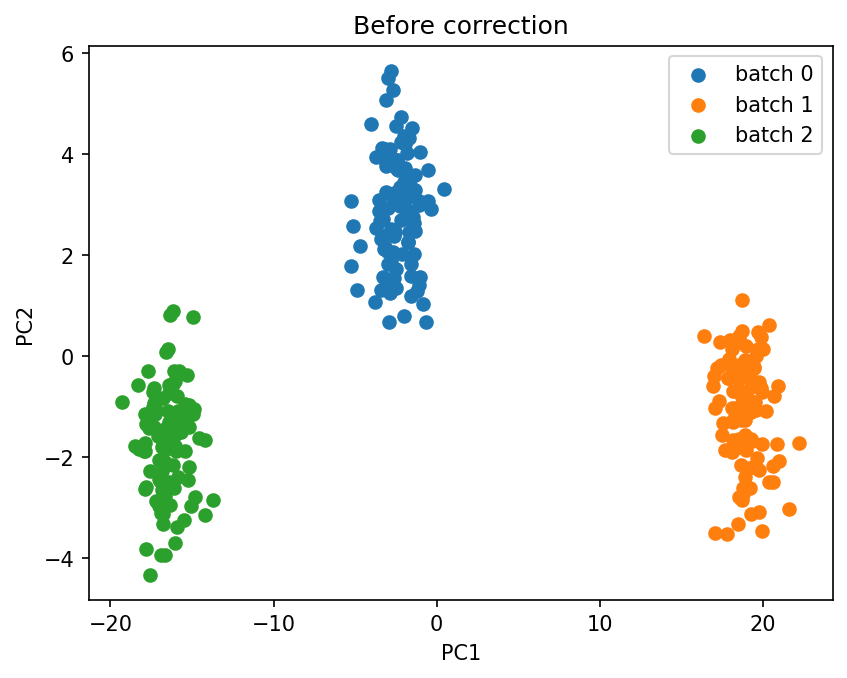

In [4]:
# Reproducibility
rng = np.random.default_rng(42)

n_samples, n_features, n_batches = 300, 50, 3
true_signal = rng.standard_normal((n_samples, n_features))

# Inject batch‑specific mean shifts
batch_effects = rng.normal(
    loc=np.array([0, 3, -2])[:, None],  # shape (3,1) for broadcasting
    scale=0.5,
    size=(n_batches, n_features),
)

batches = np.repeat(np.arange(n_batches), n_samples // n_batches)
X = true_signal.copy()

for b in range(n_batches):
    X[batches == b] += batch_effects[b]

X = pd.DataFrame(X, columns=[f"gene_{i + 1}" for i in range(n_features)])
batch_labels = pd.Series(batches.astype(str), name="batch")

plot_pca(X.values, batch_labels.values, title="Before correction")

In [5]:
# Simulate a categorical (sex) and continuous (age) covariate
sex = pd.Series(rng.choice(["M", "F"], size=n_samples), name="sex")
age = pd.Series(rng.uniform(20, 60, size=n_samples), name="age")

## The three methods

### Johnson method

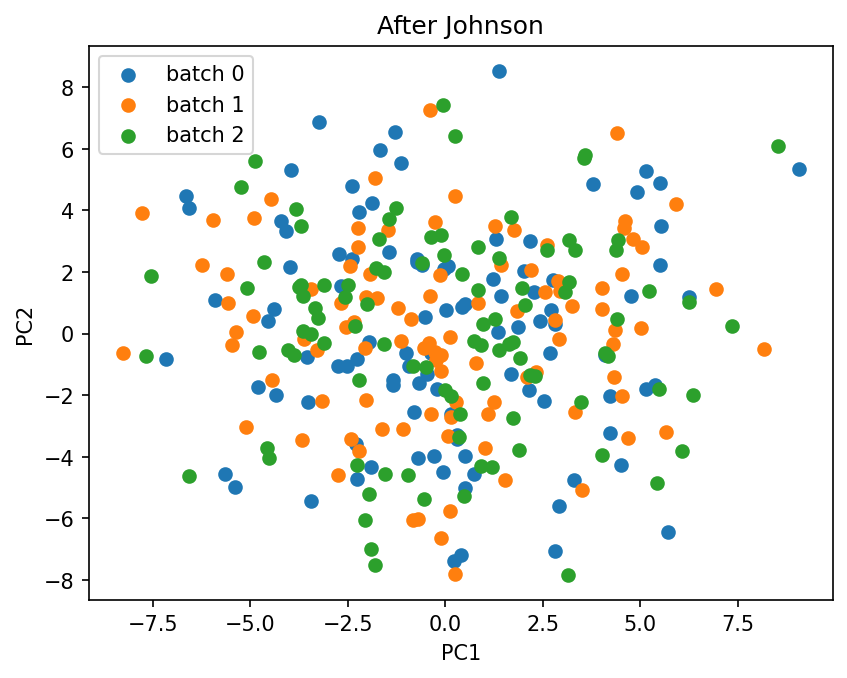

In [6]:
combat_johnson = ComBat(batch=batch_labels, method="johnson")
X_johnson = combat_johnson.fit_transform(X)

plot_pca(X_johnson.values, batch_labels.values, title="After Johnson")

Johnson's method ignores the covariates

In [7]:
combat_johnson_wc = ComBat(
    batch=batch_labels,
    discrete_covariates=sex,
    continuous_covariates=age,
    method="johnson",
)
X_johnson_wc = combat_johnson_wc.fit_transform(X)

In [8]:
print("Are all values equal?", "Yes" if np.allclose(X_johnson, X_johnson_wc) else "No")

Are all values equal? Yes


### Fortin method

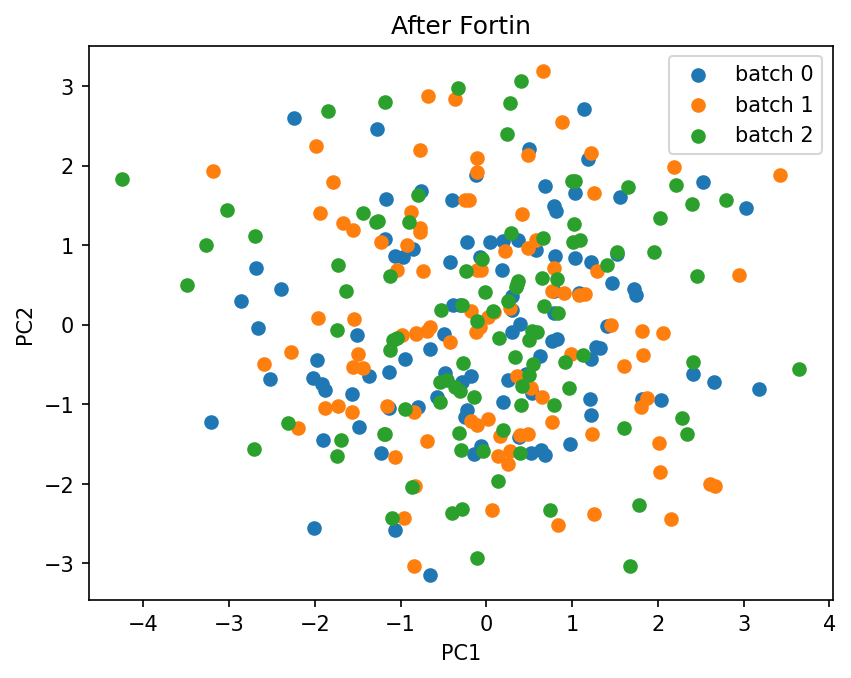

In [9]:
combat_fortin = ComBat(
    batch=batch_labels,
    discrete_covariates=sex,
    continuous_covariates=age,
    method="fortin",
)
X_fortin = combat_fortin.fit_transform(X)

plot_pca(X_fortin.values, batch_labels.values, title="After Fortin")

### Chen method

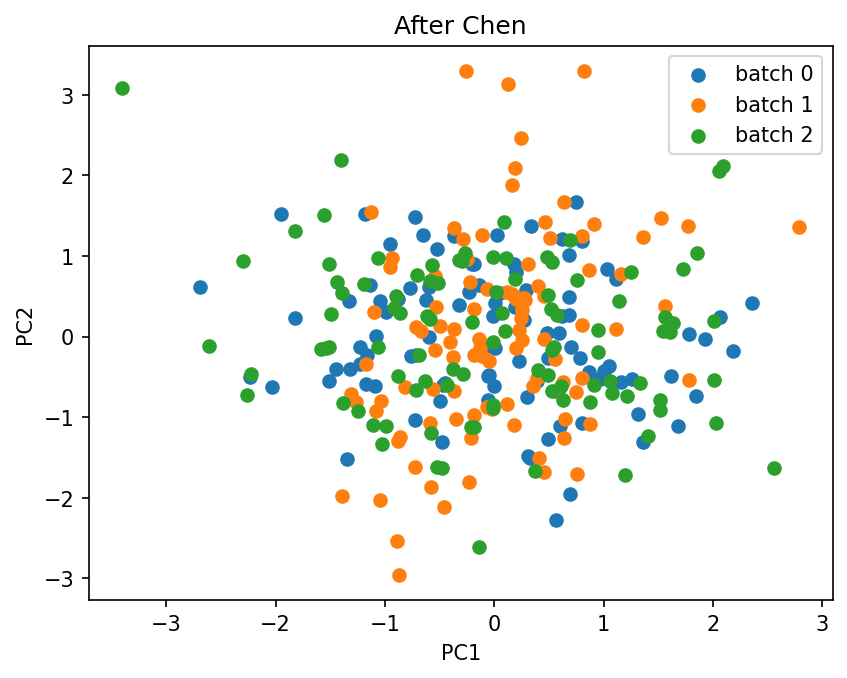

In [10]:
combat_chen = ComBat(
    batch=batch_labels,
    discrete_covariates=sex,
    continuous_covariates=age,
    method="chen",
    covbat_cov_thresh=0.95,
)
X_chen = combat_chen.fit_transform(X)

plot_pca(X_chen.values, batch_labels.values, title="After Chen")

## Parametric versus non parametric approach

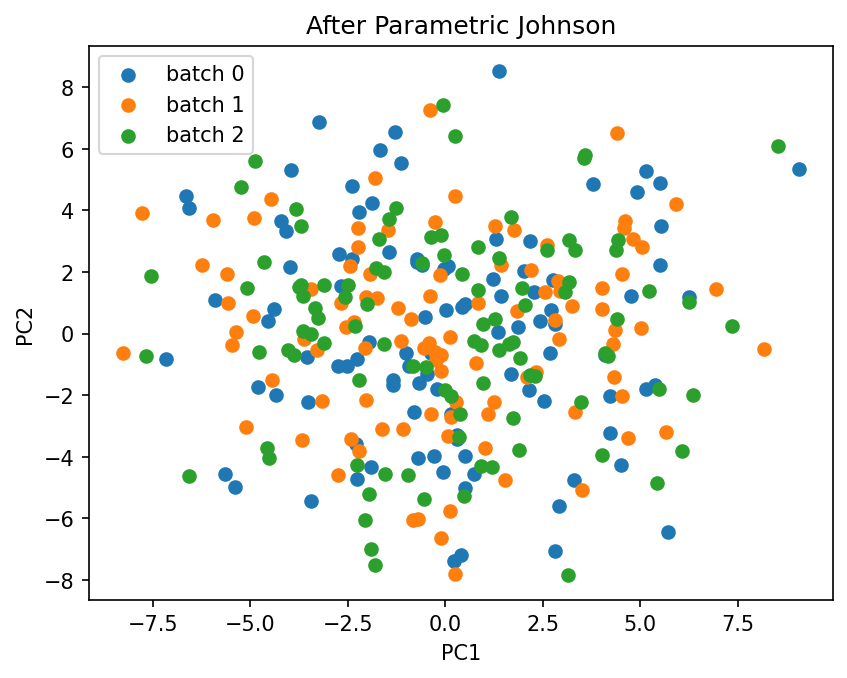

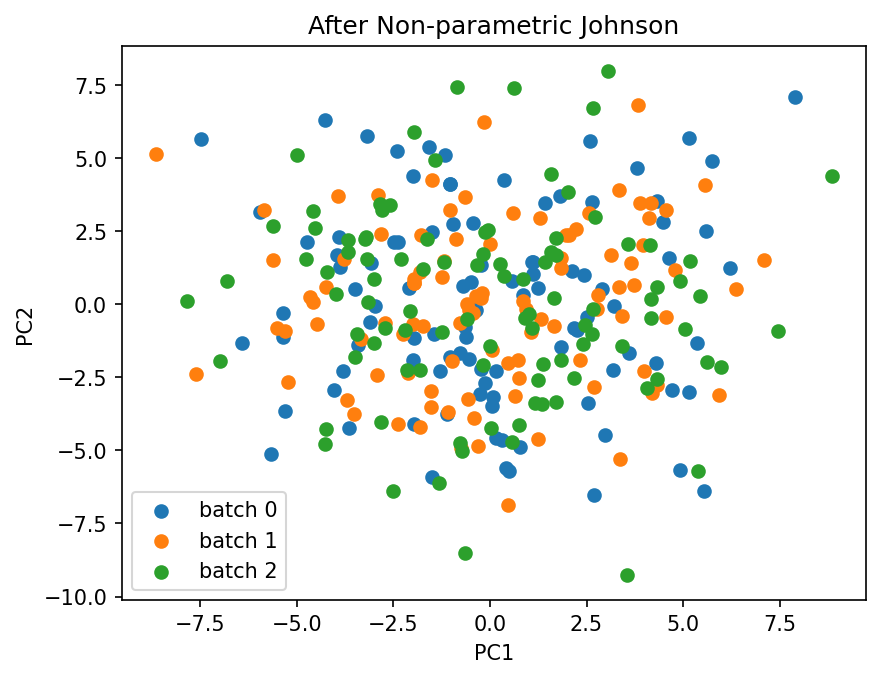

In [11]:
combat_parametric = ComBat(batch=batch_labels, method="johnson", parametric=True)
X_parametric = combat_parametric.fit_transform(X)
plot_pca(X_parametric.values, batch_labels.values, title="After Parametric Johnson")
combat_non_parametric = ComBat(batch=batch_labels, method="johnson", parametric=False)
X_non_parametric = combat_non_parametric.fit_transform(X)
plot_pca(
    X_non_parametric.values, batch_labels.values, title="After Non-parametric Johnson"
)

## Working with `sklearn`

Creating target

In [12]:
# Example: classification with a batch‑aware preprocessing pipeline
# (Here we create a toy binary label correlated with the true signal.)
y = (true_signal[:, 0] > 0).astype(int)

### Effect of ComBat in training set and test set

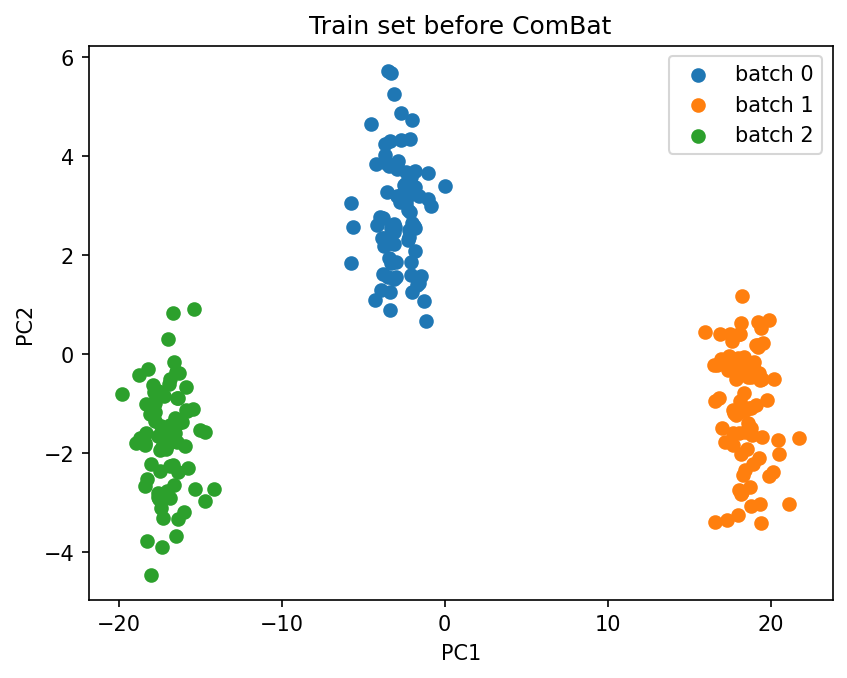

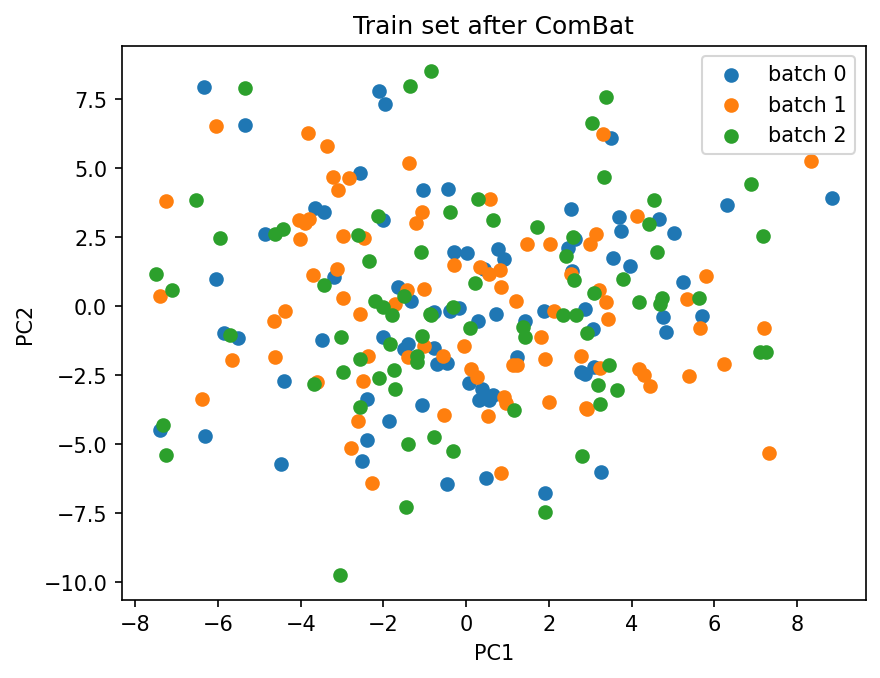

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

combat = ComBat(batch=batch_labels, method="johnson")
combat.fit(X_train)

plot_pca(
    X_train.values,
    batch_labels.iloc[X_train.index].values,
    title="Train set before ComBat",
)

X_train_combat = combat.transform(X_train)
plot_pca(
    X_train_combat.values,
    batch_labels.iloc[X_train_combat.index].values,
    title="Train set after ComBat",
)

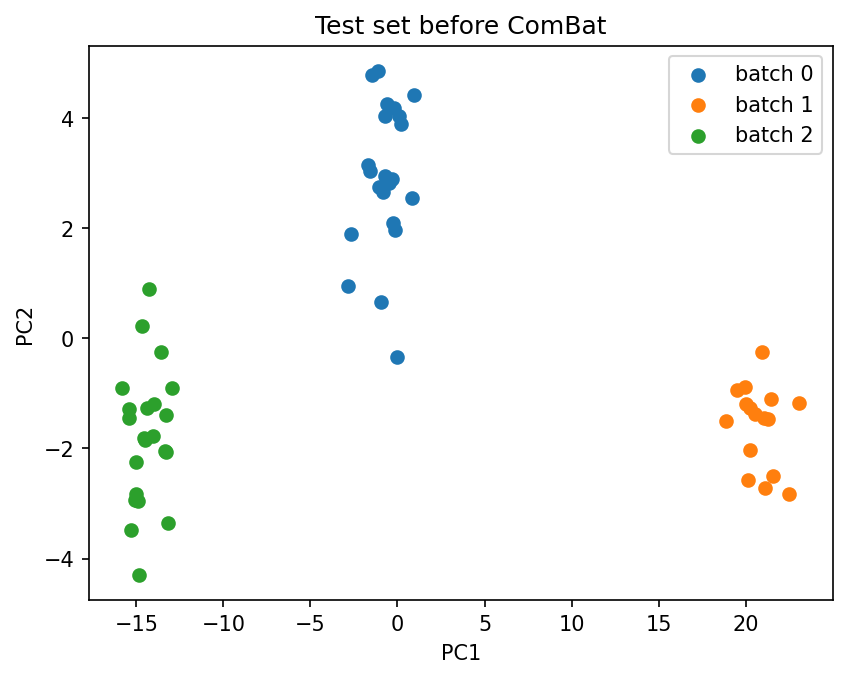

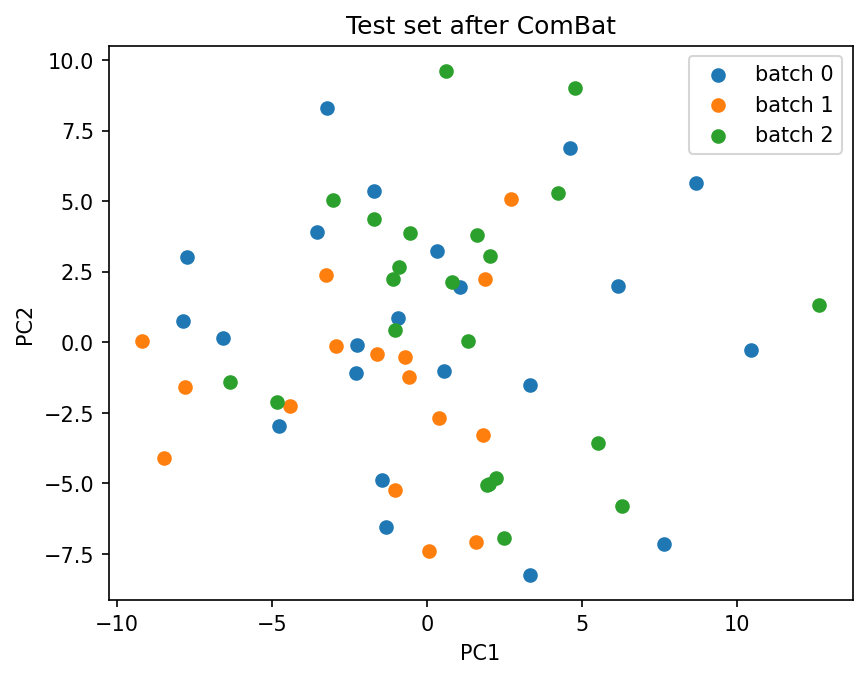

In [14]:
plot_pca(
    X_test.values,
    batch_labels.iloc[X_test.index].values,
    title="Test set before ComBat",
)

X_test_combat = combat.transform(X_test)
plot_pca(
    X_test_combat.values,
    batch_labels.iloc[X_test_combat.index].values,
    title="Test set after ComBat",
)

### Use of ComBat within a scikit-learn `Pipeline`

In [15]:
pipe = Pipeline(
    [
        ("combat", ComBat(batch=batch_labels, method="johnson")),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression()),
    ]
)

scores = cross_val_score(pipe, X, y, cv=5)
print(f"Cross‑validated accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

Cross‑validated accuracy: 0.907 ± 0.049


## New feature in `combatlearn v0.2.0`

Now you can directly use the `plot_transformation` method of the `ComBat` class for the visualization of the batch effect correction

In [16]:
combat = ComBat(batch=batch_labels, method="johnson")
_ = combat.fit(X)

PCA visualization

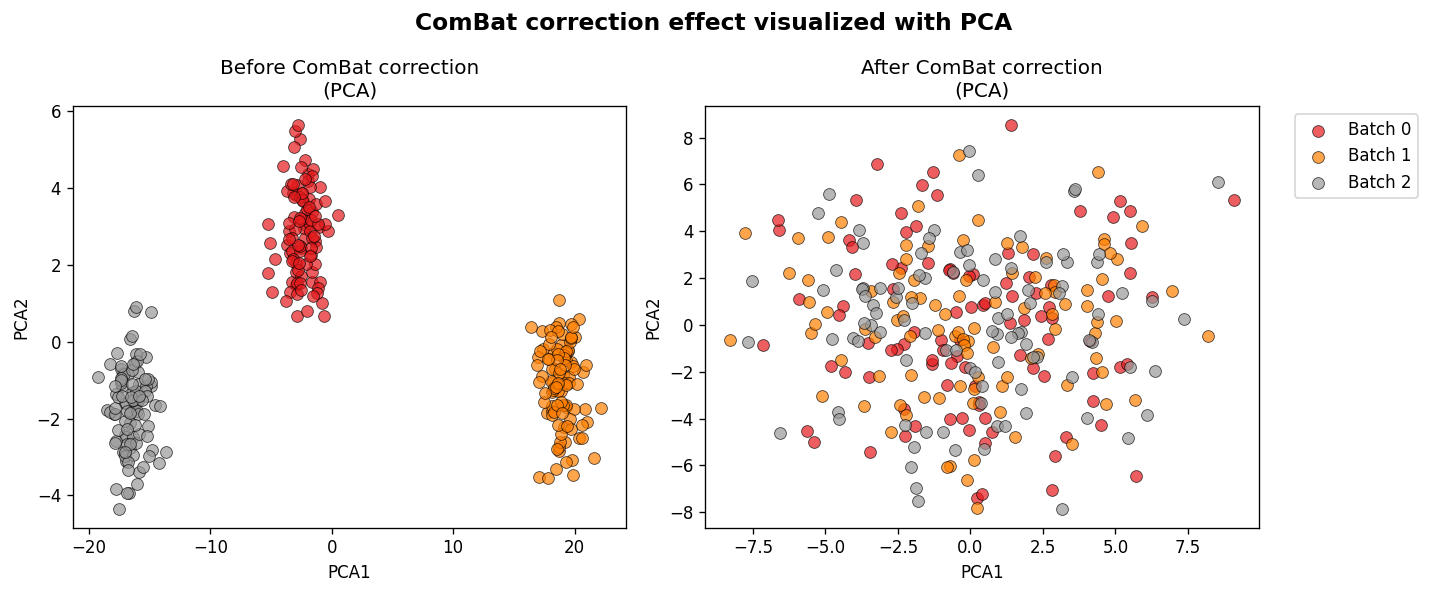

In [17]:
fig_pca = combat.plot_transformation(X)

UMAP visualization (in this example it is 3D interactive plot)

In [18]:
combat.plot_transformation(
    X, reduction_method="umap", n_components=3, plot_type="interactive", n_neighbors=30
)

TSNE visualization (with also embeddings)

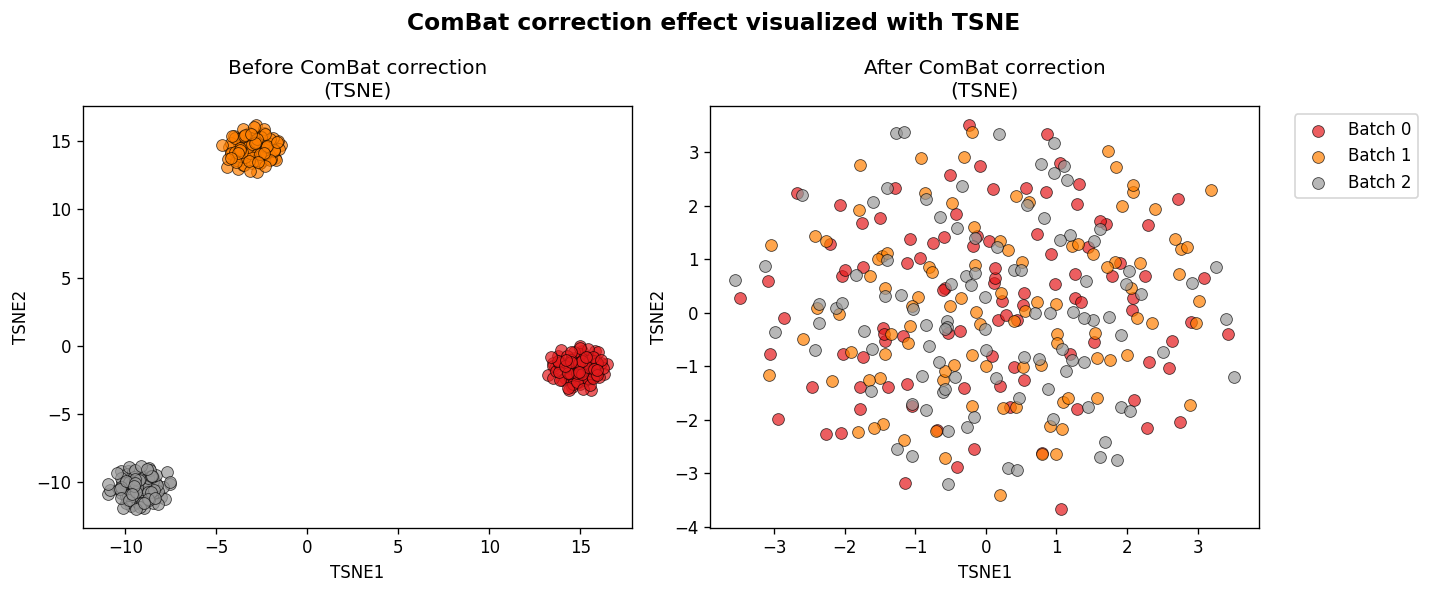

In [19]:
fig_tsne, embeddings = combat.plot_transformation(
    X, reduction_method="tsne", return_embeddings=True, perplexity=50
)

In [20]:
for k, emb in embeddings.items():
    print(f"{k}: {emb.shape}")

original: (300, 2)
transformed: (300, 2)


## Batch Effect Metrics (New in v1.1.0)

Quantitatively assess batch correction quality with the `compute_batch_metrics()` method.

The metrics include:
- **Batch effect quantification**: Silhouette, Davies-Bouldin, kBET, LISI, variance ratio
- **Structure preservation**: k-NN preservation, distance correlation
- **Alignment metrics**: Centroid distance, Levene statistic

By default, metrics are computed in the original feature space. For high-dimensional data, use the `pca_components` parameter for dimensionality reduction.

In [ ]:
# Compute metrics during fit_transform
combat_metrics = ComBat(batch=batch_labels, method="johnson", compute_metrics=True)
X_corrected = combat_metrics.fit_transform(X)

# Access cached metrics
metrics = combat_metrics.metrics_
print(f"Available categories: {list(metrics.keys())}")

Metrics computed successfully!
Available categories: ['batch_effect', 'preservation', 'alignment']


In [22]:
# View detailed batch effect metrics
print("=== Batch Effect Metrics ===")
for name, vals in metrics["batch_effect"].items():
    if name == "lisi":
        print(
            f"{name}: {vals['before']:.3f} -> {vals['after']:.3f} (max: {vals['max_value']})"
        )
    else:
        print(f"{name}: {vals['before']:.3f} -> {vals['after']:.3f}")

=== Batch Effect Metrics ===
silhouette: 0.485 -> -0.006
davies_bouldin: 0.847 -> 545.389
kbet: 0.000 -> 0.987
lisi: 1.000 -> 2.712 (max: 3)
variance_ratio: 643.171 -> 0.002


In [23]:
# View structure preservation metrics
print("=== Structure Preservation ===")
print(f"k-NN preservation: {metrics['preservation']['knn']}")
print(f"Distance correlation: {metrics['preservation']['distance_correlation']:.3f}")

print("\n=== Alignment Metrics ===")
for name, vals in metrics["alignment"].items():
    print(f"{name}: {vals['before']:.3f} -> {vals['after']:.3f}")

=== Structure Preservation ===
k-NN preservation: {5: np.float64(0.27), 10: np.float64(0.2906666666666667), 50: np.float64(0.30706666666666665)}
Distance correlation: 0.131

=== Alignment Metrics ===
centroid_distance: 23.976 -> 0.087
levene_statistic: 0.942 -> 0.182


You can also compute metrics on-demand for new/test data:

In [24]:
# Compute metrics on test data
combat = ComBat(batch=batch_labels, method="johnson")
combat.fit(X_train)

test_metrics = combat.compute_batch_metrics(
    X_test, batch=batch_labels.iloc[X_test.index], k_neighbors=[5, 10, 25]
)

print("=== Test Set Metrics ===")
print(
    f"Silhouette: {test_metrics['batch_effect']['silhouette']['before']:.3f} -> {test_metrics['batch_effect']['silhouette']['after']:.3f}"
)
print(
    f"kBET: {test_metrics['batch_effect']['kbet']['before']:.3f} -> {test_metrics['batch_effect']['kbet']['after']:.3f}"
)
print(
    f"Distance correlation: {test_metrics['preservation']['distance_correlation']:.3f}"
)

=== Test Set Metrics ===
Silhouette: 0.473 -> -0.013
kBET: 0.000 -> 0.950
Distance correlation: 0.086
